In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.discriminant_analysis import StandardScaler
from sklearn.linear_model import Ridge
from pathlib import Path
import pickle
from sklearn.dummy import DummyRegressor
import os
from sklearn.model_selection import RandomizedSearchCV

In [39]:
RANDOM_STATE = 42

In [40]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [41]:
train_data_true_known = pd.read_parquet("/home/henrik/projects/cedas2025/src/data/cedas2025_material/data/chargecurves_train.parquet")

In [42]:
len(train_data_true_known) / 40

99008.725

In [43]:
train_data_true_known.loc[train_data_true_known['id'] == 2]

,id,timestamp,soc,power,nominal_power,location_id,sub_id
40,2,2023-10-13 05:59:50,26.0,0.00,360.0,1,0
41,2,2023-10-13 06:00:50,26.0,66.06,360.0,1,1
42,2,2023-10-13 06:01:50,28.0,66.79,360.0,1,2
43,2,2023-10-13 06:02:50,29.0,67.69,360.0,1,3
44,2,2023-10-13 06:03:50,31.0,68.61,360.0,1,4
45,2,2023-10-13 06:04:50,32.0,70.25,360.0,1,5
46,2,2023-10-13 06:05:50,34.0,71.91,360.0,1,6
47,2,2023-10-13 06:06:50,36.0,73.93,360.0,1,7
48,2,2023-10-13 06:07:50,37.0,75.97,360.0,1,8
49,2,2023-10-13 06:08:50,39.0,76.18,360.0,1,9


In [44]:
def reshape_dataframe(df):
    first_timestamps = df.groupby('id')['timestamp'].first().reset_index()

    pivot_df = df.pivot(index=['id', 'nominal_power', 'location_id'],
                        columns='sub_id',
                        values=['soc', 'power']).reset_index()

    pivot_df.columns = [
        f'{col[0]}_{col[1]}' if col[1] != '' else col[0]
        for col in pivot_df.columns
    ]

    result_df = pivot_df.merge(first_timestamps, on='id')
    return result_df

In [45]:
train_data_true_known = reshape_dataframe(train_data_true_known)
len(train_data_true_known)

99581

In [46]:
train_data_true_known.head()

,id,nominal_power,location_id,soc_0,soc_1,soc_2,soc_3,soc_4,soc_5,soc_6,soc_7,soc_8,soc_9,soc_10,soc_11,soc_12,soc_13,soc_14,soc_15,soc_16,soc_17,soc_18,soc_19,soc_20,soc_21,soc_22,soc_23,soc_24,soc_25,soc_26,soc_27,soc_28,soc_29,soc_30,soc_31,soc_32,soc_33,soc_34,soc_35,soc_36,soc_37,soc_38,soc_39,power_0,power_1,power_2,power_3,power_4,power_5,power_6,power_7,power_8,power_9,power_10,power_11,power_12,power_13,power_14,power_15,power_16,power_17,power_18,power_19,power_20,power_21,power_22,power_23,power_24,power_25,power_26,power_27,power_28,power_29,power_30,power_31,power_32,power_33,power_34,power_35,power_36,power_37,power_38,power_39,timestamp
0,1,62.5,0,42.0,44.0,46.0,49.0,51.0,53.0,55.0,56.0,58.0,60.0,61.0,62.0,64.0,65.0,66.0,68.0,69.0,70.0,71.0,72.0,73.0,74.0,75.0,76.0,76.0,77.0,78.0,79.0,80.0,81.0,81.0,82.0,83.0,83.0,84.0,84.0,85.0,86.0,86.0,86.0,37.73,30.10,27.46,26.42,25.46,23.55,23.63,22.46,20.93,20.18,18.99,19.06,18.29,17.54,17.21,16.41,16.04,15.67,14.90,14.52,13.76,13.38,13.12,12.39,12.79,12.41,11.64,11.26,10.88,10.11,9.72,9.29,8.94,8.91,8.17,7.79,7.36,7.01,7.02,6.63,2023-03-15 09:46:44
1,2,360.0,1,26.0,26.0,28.0,29.0,31.0,32.0,34.0,36.0,37.0,39.0,41.0,42.0,44.0,46.0,48.0,49.0,51.0,53.0,54.0,56.0,58.0,59.0,61.0,62.0,64.0,65.0,67.0,68.0,69.0,71.0,72.0,73.0,75.0,76.0,77.0,78.0,80.0,81.0,82.0,83.0,0.00,66.06,66.79,67.69,68.61,70.25,71.91,73.93,75.97,76.18,76.01,76.96,72.72,74.03,74.97,74.80,73.88,73.32,72.38,70.31,68.60,67.64,67.06,65.70,64.34,63.74,62.76,61.76,61.15,60.14,58.35,57.72,56.16,54.35,54.10,53.06,52.40,51.35,49.10,47.12,2023-10-13 05:59:50
2,3,62.5,2,60.0,60.0,61.0,62.0,63.0,64.0,65.0,66.0,68.0,68.0,69.0,70.0,71.0,72.0,73.0,74.0,75.0,75.0,76.0,77.0,77.0,78.0,80.0,80.0,80.0,80.0,81.0,82.0,82.0,83.0,83.0,83.0,84.0,84.0,85.0,85.0,86.0,86.0,86.0,87.0,33.95,25.42,24.64,24.67,24.68,24.71,24.73,24.69,23.64,22.47,21.80,21.03,21.02,20.99,20.76,20.39,19.69,19.32,18.81,18.19,17.84,17.45,17.00,17.13,16.33,15.88,15.52,15.26,14.83,14.41,14.44,13.64,13.29,12.63,12.61,11.79,11.46,11.07,11.06,10.67,2024-01-23 04:21:08
3,4,50.0,3,59.0,59.0,60.0,61.0,61.0,62.0,63.0,63.0,64.0,64.0,65.0,65.0,66.0,66.0,67.0,67.0,68.0,68.0,69.0,69.0,70.0,70.0,71.0,71.0,71.0,72.0,72.0,72.0,73.0,73.0,73.0,74.0,74.0,74.0,75.0,75.0,75.0,76.0,76.0,76.0,0.00,17.95,13.43,14.66,13.16,12.82,12.85,11.72,11.37,11.40,11.02,10.67,10.67,10.70,11.08,10.70,10.75,10.31,10.37,10.37,9.60,9.98,8.83,8.83,8.79,9.22,8.81,9.24,9.22,9.22,8.83,9.26,8.88,8.86,8.49,6.91,7.30,7.32,7.30,7.70,2023-12-25 10:45:39
4,5,150.0,4,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,19.0,19.0,19.0,20.0,20.0,21.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,29.0,30.0,31.0,33.0,34.0,35.0,37.0,38.0,39.0,40.0,42.0,0.37,3.38,3.35,3.35,3.72,3.32,3.35,3.35,3.35,3.35,3.35,4.03,6.37,8.79,11.17,13.81,16.64,19.49,22.26,25.36,28.53,32.01,35.60,39.84,47.25,49.16,58.13,70.96,72.46,71.19,70.62,70.01,69.69,68.74,67.49,67.65,66.82,66.21,65.08,64.36,2022-12-12 18:39:31


In [47]:
train_data_true_known = train_data_true_known.dropna()
len(train_data_true_known)

97751

In [48]:
unique_values = train_data_true_known['location_id'].nunique()
print(unique_values)

306


In [49]:
# remove rows where power_any is over 500
POWER_COLOUMNS_ALL = [f'power_{i}' for i in range(40)]
train_data_true_known = train_data_true_known[train_data_true_known[POWER_COLOUMNS_ALL].le(500).all(axis=1)]

In [50]:
len(train_data_true_known)

97732

In [51]:
train_data, temp_data = train_test_split(train_data_true_known,
                                         train_size=0.80,
                                         test_size=0.20,
                                         shuffle=True,
                                         random_state=RANDOM_STATE)
validation_data, test_data = train_test_split(temp_data,
                                              train_size=0.5,
                                              test_size=0.5,
                                              random_state=RANDOM_STATE)


In [52]:
def add_month_col(df):
    df["month"] = df["timestamp"].dt.month
    return df

train_data = add_month_col(train_data)
validation_data = add_month_col(validation_data)
test_data = add_month_col(test_data)

In [53]:
def add_temp_col(df):
  temperature_data = {
      'month': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
      'temperatur': [-4, -4, 0, 5, 10, 14, 17, 15, 11, 5, 1, -3] # data fra https://www.timeanddate.no/vaer/@9151180/klima
  }
  temp_df = pd.DataFrame(temperature_data)
  df = df.merge(temp_df, on='month', how='left')
  df = df.drop(columns=['month'])
  return df

train_data = add_temp_col(train_data)
validation_data = add_temp_col(validation_data)
test_data = add_temp_col(test_data)

In [54]:
SOC_COLOUMNS_SUBSET = [f'soc_{i}' for i in range(10)]
POWER_COLOUMNS_SUBSET = [f'power_{i}' for i in range(10)]

TARGET_POWER = [f'power_{i}' for i in range(10, 40)]
TARGET_SOC = [f'soc_{i}' for i in range(10, 40)] # no longer a target to predict!

REMOVE = ["id", "timestamp"]
TO_DROP_FROM_X = TARGET_POWER + TARGET_SOC + REMOVE

INPUT_FEATURES_CLUSTERING = [col for col in train_data.columns.tolist() if col not in TO_DROP_FROM_X ]

print(INPUT_FEATURES_CLUSTERING)


['nominal_power', 'location_id', 'soc_0', 'soc_1', 'soc_2', 'soc_3', 'soc_4', 'soc_5', 'soc_6', 'soc_7', 'soc_8', 'soc_9', 'power_0', 'power_1', 'power_2', 'power_3', 'power_4', 'power_5', 'power_6', 'power_7', 'power_8', 'power_9', 'temperatur']


In [55]:
train_data_first_ten = train_data[INPUT_FEATURES_CLUSTERING]
validation_data_first_ten = validation_data[INPUT_FEATURES_CLUSTERING]
test_data_first_ten = test_data[INPUT_FEATURES_CLUSTERING]

In [56]:
train_data_first_ten.head()

,nominal_power,location_id,soc_0,soc_1,soc_2,soc_3,soc_4,soc_5,soc_6,soc_7,soc_8,soc_9,power_0,power_1,power_2,power_3,power_4,power_5,power_6,power_7,power_8,power_9,temperatur
0,100.0,150,53.0,54.0,54.0,55.0,56.0,56.0,58.0,59.0,59.0,60.0,15.04,14.76,15.01,15.06,15.03,15.04,15.42,15.33,15.40,15.33,-4
1,150.0,101,10.0,13.0,15.0,18.0,20.0,23.0,25.0,28.0,30.0,33.0,66.27,60.10,64.59,64.91,68.69,60.86,62.18,62.24,66.42,66.54,1
2,150.0,16,25.0,26.0,28.0,29.0,31.0,33.0,34.0,35.0,37.0,39.0,75.55,82.85,86.96,90.10,89.40,82.22,79.15,73.46,84.85,95.53,-4
3,180.0,45,35.0,36.0,37.0,38.0,39.0,40.0,41.0,42.0,43.0,44.0,0.00,41.06,42.00,42.48,42.60,42.96,42.96,43.44,44.16,44.29,0
4,62.5,64,38.0,40.0,42.0,45.0,47.0,49.0,51.0,53.0,55.0,57.0,45.34,45.92,46.16,46.53,46.89,45.95,41.79,39.13,36.51,35.02,11


In [57]:
CLUSTER_MODEL_TRAINED = True

if CLUSTER_MODEL_TRAINED:

    load_dir = "/home/henrik/projects/cedas2025/src/henrik/models2/clustering/cluster_model.pkl"

    with open(load_dir, 'rb') as f:
        clustering_pipeline = pickle.load(f)


    print("Loaded cluster model")


Loaded cluster model


In [58]:
if not CLUSTER_MODEL_TRAINED:
    clustering_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("cluster_model", KMeans(random_state=RANDOM_STATE, n_clusters=8))
    ])
    clustering_pipeline.fit(train_data_first_ten)

In [59]:
labels = clustering_pipeline.named_steps["cluster_model"].labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print(f"Estimated number of clusters: {n_clusters_}")
print(f"Estimated number of noise points: {n_noise_}")

Estimated number of clusters: 8
Estimated number of noise points: 0


In [60]:
if not CLUSTER_MODEL_TRAINED:
    save_dir_cluster = Path("/home/henrik/projects/cedas2025/src/henrik/models2/clustering/")

    model_name = f"cluster_model.pkl"
    pth = save_dir_cluster / model_name
    with open(pth, 'wb') as file:
        pickle.dump(clustering_pipeline, file)

In [61]:
validation_data_first_ten

,nominal_power,location_id,soc_0,soc_1,soc_2,soc_3,soc_4,soc_5,soc_6,soc_7,soc_8,soc_9,power_0,power_1,power_2,power_3,power_4,power_5,power_6,power_7,power_8,power_9,temperatur
0,150.0,182,38.0,38.0,39.0,39.0,40.0,40.0,40.0,40.0,42.0,43.0,24.30,24.11,24.02,25.09,26.00,27.50,28.97,30.81,32.28,33.73,-4
1,180.0,44,24.0,25.0,27.0,29.0,31.0,33.0,34.0,36.0,38.0,40.0,0.00,43.38,44.11,47.15,44.73,44.84,49.53,48.84,43.96,44.36,5
2,350.0,6,9.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,19.0,20.0,48.38,35.80,36.01,36.11,36.21,36.21,36.31,35.96,41.53,42.00,0
3,62.5,31,18.0,20.0,21.0,23.0,25.0,28.0,30.0,33.0,35.0,38.0,44.15,44.87,45.35,45.60,45.87,46.03,46.23,46.39,46.64,46.77,5
4,150.0,23,58.0,59.0,61.0,62.0,63.0,65.0,66.0,67.0,68.0,70.0,45.05,45.54,46.54,47.09,45.84,44.99,44.05,43.02,41.83,40.95,-3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9768,50.0,27,25.0,26.0,28.0,29.0,31.0,32.0,33.0,35.0,36.0,37.0,0.00,50.00,49.72,49.85,49.17,49.57,49.69,49.41,49.82,49.53,5
9769,50.0,39,27.0,29.0,31.0,34.0,36.0,38.0,41.0,43.0,45.0,47.0,0.00,44.29,44.40,44.64,44.88,45.12,45.36,42.71,39.69,37.80,0
9770,150.0,16,21.0,23.0,26.0,28.0,30.0,32.0,34.0,35.0,39.0,40.0,35.88,35.96,33.55,33.14,39.78,36.10,37.16,40.43,40.66,43.04,1
9771,360.0,55,2.0,3.0,6.0,9.0,12.0,15.0,17.0,21.0,24.0,27.0,0.00,116.42,121.18,126.00,136.15,146.06,152.93,147.14,141.32,136.78,5


In [62]:
train_data_first_ten['cluster'] = labels
train_data['cluster'] = labels

validation_clusters = clustering_pipeline.predict(validation_data_first_ten)
validation_data_first_ten['cluster'] = validation_clusters
validation_data['cluster'] = validation_clusters

test_clusters = clustering_pipeline.predict(test_data_first_ten)
test_data_first_ten['cluster'] = test_clusters
test_data['cluster'] = test_clusters

/tmp/ipykernel_28585/2794204716.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_first_ten['cluster'] = labels
/tmp/ipykernel_28585/2794204716.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_data_first_ten['cluster'] = validation_clusters
/tmp/ipykernel_28585/2794204716.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

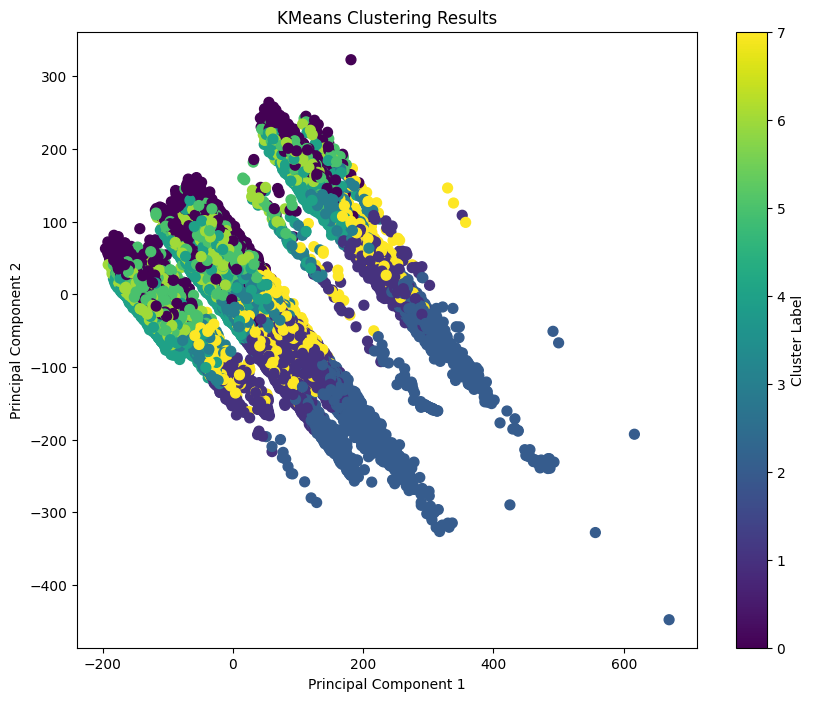

In [63]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(train_data_first_ten)

plt.figure(figsize=(10, 8))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='viridis', s=50)
plt.colorbar(label='Cluster Label')
plt.title('KMeans Clustering Results')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [64]:
# one hot encode cluster
encoder = OneHotEncoder(drop=None, sparse_output=False)
encoder.fit(train_data[['cluster']])

def one_hot_encode_and_concat(df, encoder, column_name='cluster'):
    one_hot_encoded_array = encoder.transform(df[[column_name]])

    one_hot_encoded_df = pd.DataFrame(one_hot_encoded_array,
                                      columns=[f'{column_name}_{int(cat)}' for cat in encoder.categories_[0]],
                                      index=df.index)

    df_with_one_hot = pd.concat([df, one_hot_encoded_df], axis=1)
    return df_with_one_hot

train_data_first_ten = one_hot_encode_and_concat(train_data_first_ten, encoder)
train_data = one_hot_encode_and_concat(train_data, encoder)

validation_data_first_ten = one_hot_encode_and_concat(validation_data_first_ten, encoder)
validation_data = one_hot_encode_and_concat(validation_data, encoder)

test_data_first_ten = one_hot_encode_and_concat(test_data_first_ten, encoder)
test_data = one_hot_encode_and_concat(test_data, encoder)

In [65]:
train_data.head()

,id,nominal_power,location_id,soc_0,soc_1,soc_2,soc_3,soc_4,soc_5,soc_6,soc_7,soc_8,soc_9,soc_10,soc_11,soc_12,soc_13,soc_14,soc_15,soc_16,soc_17,soc_18,soc_19,soc_20,soc_21,soc_22,soc_23,soc_24,soc_25,soc_26,soc_27,soc_28,soc_29,soc_30,soc_31,soc_32,soc_33,soc_34,soc_35,soc_36,soc_37,soc_38,soc_39,power_0,power_1,power_2,power_3,power_4,power_5,power_6,power_7,power_8,power_9,power_10,power_11,power_12,power_13,power_14,power_15,power_16,power_17,power_18,power_19,power_20,power_21,power_22,power_23,power_24,power_25,power_26,power_27,power_28,power_29,power_30,power_31,power_32,power_33,power_34,power_35,power_36,power_37,power_38,power_39,timestamp,temperatur,cluster,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7
0,64754,100.0,150,53.0,54.0,54.0,55.0,56.0,56.0,58.0,59.0,59.0,60.0,61.0,62.0,63.0,63.0,64.0,65.0,66.0,67.0,68.0,68.0,69.0,70.0,71.0,71.0,73.0,73.0,74.0,75.0,76.0,77.0,78.0,78.0,79.0,86.0,86.0,86.0,88.0,89.0,89.0,90.0,15.04,14.76,15.01,15.06,15.03,15.04,15.42,15.33,15.40,15.33,15.50,15.42,15.45,15.47,15.88,15.95,15.90,15.89,15.84,16.04,16.07,15.77,15.75,15.81,15.80,16.18,16.14,16.27,16.26,16.25,16.71,16.74,16.70,14.35,13.68,13.66,13.28,13.00,12.22,11.86,2024-01-04 09:17:58,-4,5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,37916,150.0,101,10.0,13.0,15.0,18.0,20.0,23.0,25.0,28.0,30.0,33.0,35.0,37.0,40.0,42.0,44.0,46.0,48.0,50.0,52.0,54.0,55.0,56.0,59.0,61.0,63.0,65.0,66.0,68.0,70.0,71.0,73.0,74.0,76.0,77.0,79.0,80.0,81.0,83.0,84.0,85.0,66.27,60.10,64.59,64.91,68.69,60.86,62.18,62.24,66.42,66.54,60.68,64.54,51.55,51.71,51.80,51.98,55.72,55.91,56.09,51.36,51.34,51.46,51.73,51.97,54.75,46.56,46.70,46.91,46.99,47.14,41.35,41.63,41.59,39.82,40.06,38.26,38.39,38.46,38.11,18.38,2022-11-11 05:14:07,1,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,123346,150.0,16,25.0,26.0,28.0,29.0,31.0,33.0,34.0,35.0,37.0,39.0,40.0,43.0,45.0,48.0,50.0,54.0,56.0,56.0,59.0,61.0,63.0,65.0,67.0,69.0,71.0,73.0,75.0,76.0,78.0,80.0,81.0,82.0,85.0,86.0,88.0,89.0,91.0,92.0,93.0,93.0,75.55,82.85,86.96,90.10,89.40,82.22,79.15,73.46,84.85,95.53,99.33,110.17,127.76,148.57,148.80,98.62,98.47,99.43,101.89,102.31,102.78,103.39,103.73,104.21,104.73,105.15,105.84,106.29,106.67,97.37,94.38,89.94,85.20,83.44,79.82,75.81,73.80,60.20,52.74,43.01,2022-02-26 23:58:56,-4,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,121473,180.0,45,35.0,36.0,37.0,38.0,39.0,40.0,41.0,42.0,43.0,44.0,45.0,47.0,48.0,49.0,50.0,51.0,52.0,53.0,54.0,55.0,56.0,57.0,58.0,59.0,61.0,62.0,63.0,64.0,65.0,67.0,68.0,69.0,70.0,71.0,72.0,73.0,74.0,76.0,77.0,77.0,0.00,41.06,42.00,42.48,42.60,42.96,42.96,43.44,44.16,44.29,44.29,44.29,44.04,44.41,44.17,44.53,44.29,45.14,45.63,46.13,46.99,48.23,48.36,47.00,47.50,48.13,48.63,49.52,49.27,49.15,48.51,47.88,47.23,46.20,45.16,44.12,43.46,42.01,40.07,38.22,2024-03-10 13:54:56,0,6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,41368,62.5,64,38.0,40.0,42.0,45.0,47.0,49.0,51.0,53.0,55.0,57.0,60.0,60.0,62.0,63.0,65.0,66.0,67.0,69.0,70.0,71.0,72.0,74.0,75.0,76.0,77.0,78.0,80.0,80.0,81.0,82.0,83.0,83.0,84.0,85.0,86.0,86.0,87.0,87.0,88.0,88.0,45.34,45.92,46.16,46.53,46.89,45.95,41.79,39.13,36.51,35.02,33.92,32.86,31.36,30.25,29.14,28.01,26.50,26.14,25.80,25.16,24.49,24.12,23.42,22.64,22.28,21.10,20.82,20.50,19.70,18.98,18.57,18.24,16.99,15.84,15.06,13.83,13.20,12.29,11.57,10.74,2023-09-12 09:12:01,11,5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [66]:
train_data_first_ten.head()

,nominal_power,location_id,soc_0,soc_1,soc_2,soc_3,soc_4,soc_5,soc_6,soc_7,soc_8,soc_9,power_0,power_1,power_2,power_3,power_4,power_5,power_6,power_7,power_8,power_9,temperatur,cluster,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7
0,100.0,150,53.0,54.0,54.0,55.0,56.0,56.0,58.0,59.0,59.0,60.0,15.04,14.76,15.01,15.06,15.03,15.04,15.42,15.33,15.40,15.33,-4,5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,150.0,101,10.0,13.0,15.0,18.0,20.0,23.0,25.0,28.0,30.0,33.0,66.27,60.10,64.59,64.91,68.69,60.86,62.18,62.24,66.42,66.54,1,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,150.0,16,25.0,26.0,28.0,29.0,31.0,33.0,34.0,35.0,37.0,39.0,75.55,82.85,86.96,90.10,89.40,82.22,79.15,73.46,84.85,95.53,-4,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,180.0,45,35.0,36.0,37.0,38.0,39.0,40.0,41.0,42.0,43.0,44.0,0.00,41.06,42.00,42.48,42.60,42.96,42.96,43.44,44.16,44.29,0,6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,62.5,64,38.0,40.0,42.0,45.0,47.0,49.0,51.0,53.0,55.0,57.0,45.34,45.92,46.16,46.53,46.89,45.95,41.79,39.13,36.51,35.02,11,5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [67]:
def plot_mean():
    # avg across all time steps
    cluster_avg_soc = train_data_first_ten.groupby('cluster')[SOC_COLOUMNS_SUBSET].mean().mean(axis=1)
    cluster_avg_power = train_data_first_ten.groupby('cluster')[POWER_COLOUMNS_SUBSET].mean().mean(axis=1)
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Bar chart for average SOC
    axes[0].bar(cluster_avg_soc.index, cluster_avg_soc.values, color='b')
    axes[0].set_title('Average SOC per Cluster')
    axes[0].set_xlabel('Cluster')
    axes[0].set_ylabel('Average SOC')
    axes[0].grid(True)

    # Bar chart for average Power
    axes[1].bar(cluster_avg_power.index, cluster_avg_power.values, color='r')
    axes[1].set_title('Average Power per Cluster')
    axes[1].set_xlabel('Cluster')
    axes[1].set_ylabel('Average Power')
    axes[1].grid(True)

    # Bar chart for most common Location
    # axes[2].bar(cluster_avg_power.index, cluster_avg_power.values, color='r')
    # axes[2].set_title('Most common Location per Cluster')
    # axes[2].set_xlabel('Cluster')
    # axes[2].set_ylabel('Most common location')
    # axes[2].grid(True)

    plt.tight_layout()
    plt.show()


In [68]:
def plot_variation():
    # by cluster
    soc_data = train_data_first_ten.melt(id_vars=['cluster'], value_vars=SOC_COLOUMNS_SUBSET, var_name='SOC_Timestep', value_name='SOC')
    power_data = train_data_first_ten.melt(id_vars=['cluster'], value_vars=POWER_COLOUMNS_SUBSET, var_name='Power_Timestep', value_name='Power')

    plt.figure(figsize=(18, 8))

    # soc
    plt.subplot(1, 2, 1)
    sns.boxplot(x='cluster', y='SOC', data=soc_data, palette='Blues')
    plt.title('SOC Variation by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('SOC')

    # power
    plt.subplot(1, 2, 2)
    sns.boxplot(x='cluster', y='Power', data=power_data, palette='Reds')
    plt.title('Power Variation by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Power')

    plt.tight_layout()
    plt.show()

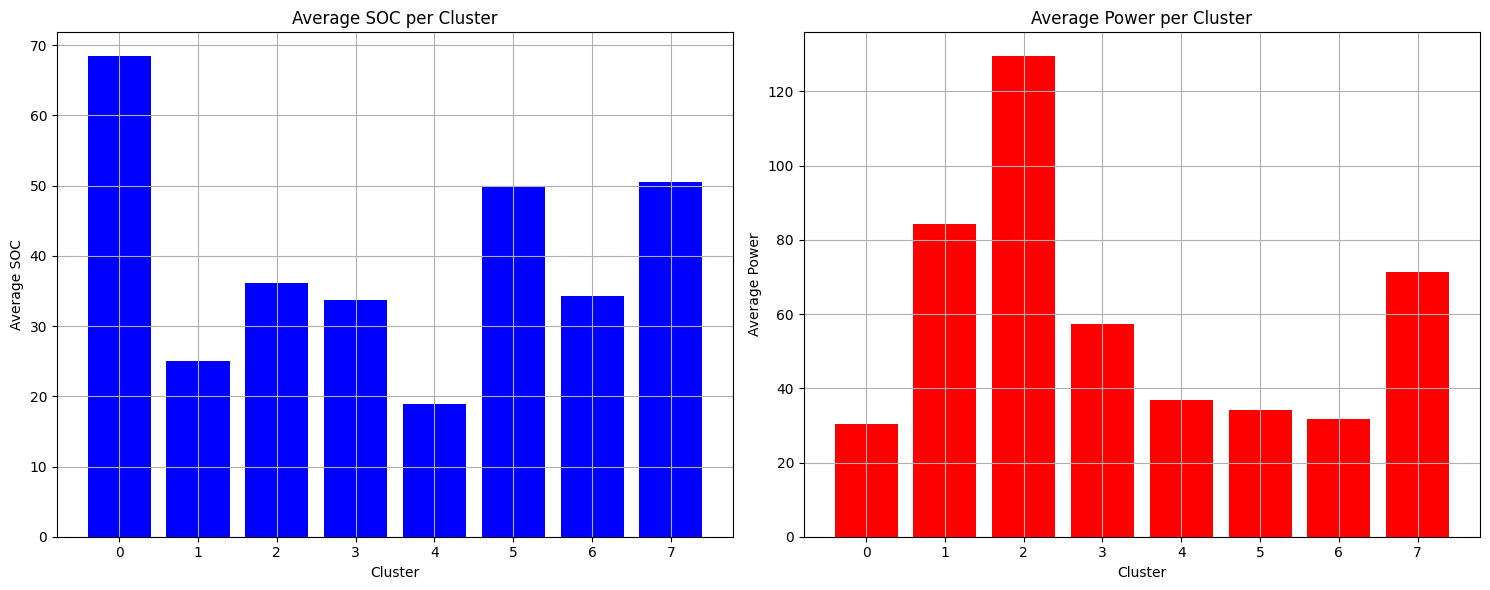

/tmp/ipykernel_28585/1208363801.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='SOC', data=soc_data, palette='Blues')
/tmp/ipykernel_28585/1208363801.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='Power', data=power_data, palette='Reds')


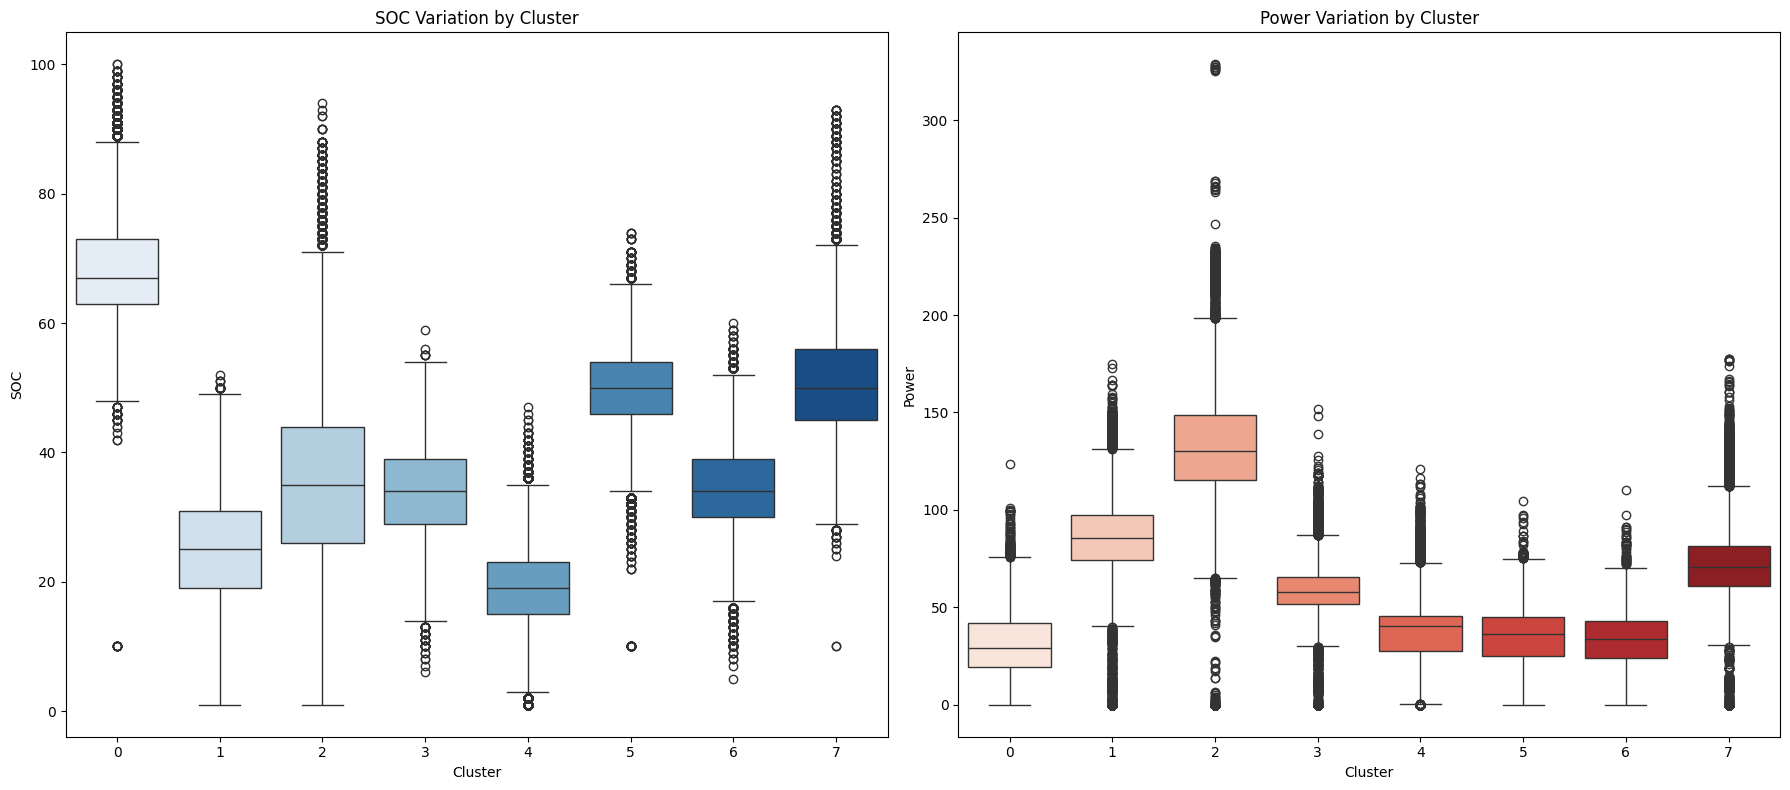

In [69]:
plot_mean()
plot_variation()

In [70]:
def get_model_pipeline():
    return Pipeline([
        ('scaler', MinMaxScaler()),
        ('poly', PolynomialFeatures()),
        ('pca', PCA()),
        ('regressor', MultiOutputRegressor(Ridge(random_state=RANDOM_STATE, alpha=0.1))),
    ])

In [71]:
TARGET_POWER = [f'power_{i}' for i in range(10, 40)]
TARGET_SOC = [f'soc_{i}' for i in range(10, 40)]

REMOVE = ["cluster","month","timestamp","id"]
TO_DROP_FROM_X = TARGET_POWER + TARGET_SOC + REMOVE

all_columns = train_data.columns.tolist()

# model inputs
INPUT_FEATURES_MODEL = [col for col in all_columns if col not in TO_DROP_FROM_X ]


In [72]:
train_data[INPUT_FEATURES_MODEL]

,nominal_power,location_id,soc_0,soc_1,soc_2,soc_3,soc_4,soc_5,soc_6,soc_7,soc_8,soc_9,power_0,power_1,power_2,power_3,power_4,power_5,power_6,power_7,power_8,power_9,temperatur,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7
0,100.0,150,53.0,54.0,54.0,55.0,56.0,56.0,58.0,59.0,59.0,60.0,15.04,14.76,15.01,15.06,15.03,15.04,15.42,15.33,15.40,15.33,-4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,150.0,101,10.0,13.0,15.0,18.0,20.0,23.0,25.0,28.0,30.0,33.0,66.27,60.10,64.59,64.91,68.69,60.86,62.18,62.24,66.42,66.54,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,150.0,16,25.0,26.0,28.0,29.0,31.0,33.0,34.0,35.0,37.0,39.0,75.55,82.85,86.96,90.10,89.40,82.22,79.15,73.46,84.85,95.53,-4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,180.0,45,35.0,36.0,37.0,38.0,39.0,40.0,41.0,42.0,43.0,44.0,0.00,41.06,42.00,42.48,42.60,42.96,42.96,43.44,44.16,44.29,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,62.5,64,38.0,40.0,42.0,45.0,47.0,49.0,51.0,53.0,55.0,57.0,45.34,45.92,46.16,46.53,46.89,45.95,41.79,39.13,36.51,35.02,11,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78180,200.0,254,44.0,44.0,45.0,46.0,48.0,49.0,50.0,50.0,52.0,54.0,46.98,47.51,47.97,48.44,48.88,49.37,49.73,50.10,50.02,49.57,5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
78181,360.0,75,68.0,68.0,69.0,69.0,70.0,71.0,72.0,72.0,73.0,73.0,0.00,29.80,34.09,29.18,29.26,29.26,28.56,27.79,27.86,27.86,11,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78182,50.0,138,62.0,63.0,63.0,64.0,65.0,65.0,66.0,66.0,67.0,68.0,0.00,37.32,36.67,35.91,35.25,35.25,36.01,38.00,40.01,41.64,-3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78183,200.0,56,19.0,19.0,20.0,20.0,21.0,21.0,22.0,23.0,23.0,24.0,27.27,26.69,26.78,26.75,26.85,27.61,27.94,28.34,31.20,33.34,-3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [73]:
models_power = {}

POWER_MODEL_TRAINED = False

if POWER_MODEL_TRAINED:

    load_dir = "/home/henrik/projects/cedas2025/src/henrik/models2/power"

    for i in range(8):
        model_filename = os.path.join(load_dir, f"power_{i}.pkl")

        with open(model_filename, 'rb') as f:
            models_power[i] = pickle.load(f)


    print("Loaded models:", models_power)


: 

In [ ]:
param_dist = {
    'poly__degree': [2, 3],
    'pca__n_components': [None, 0.5]
}

def train_power():
    for cluster in range(n_clusters_):
        one_hot_col = f'cluster_{cluster}'

        # rows in cluster
        train_subset = train_data[train_data[one_hot_col] == 1]

        # feature and target
        X_train = train_subset[INPUT_FEATURES_MODEL]
        y_train = train_subset[TARGET_POWER]

        pipeline = get_model_pipeline()

        randomized_search = RandomizedSearchCV(
            estimator=pipeline,
            param_distributions=param_dist,
            n_iter=5,
            scoring="neg_mean_absolute_error",
            cv=2,
            verbose=2,
            n_jobs=-1,
            random_state=RANDOM_STATE
        )

        randomized_search.fit(X_train, y_train)

        print(f"Cluster {cluster}: Best Params: {randomized_search.best_params_}")
        print(f"Cluster {cluster}: Best CV Score (neg MAE): {randomized_search.best_score_:.3f}")

        models_power[cluster] = randomized_search.best_estimator_
        print(f"trained model {cluster} with {len(train_subset)} data points")

if not POWER_MODEL_TRAINED:
    train_power()


Fitting 2 folds for each of 4 candidates, totalling 8 fits


/home/henrik/.cache/pypoetry/virtualenvs/cedas2025-D-Y6KMbq-py3.11/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END ..............pca__n_components=0.5, poly__degree=2; total time=   0.7s
[CV] END ..............pca__n_components=0.5, poly__degree=2; total time=   1.2s
[CV] END .............pca__n_components=None, poly__degree=2; total time=   4.1s
[CV] END .............pca__n_components=None, poly__degree=2; total time=   4.3s
[CV] END ..............pca__n_components=0.5, poly__degree=3; total time= 2.1min
[CV] END ..............pca__n_components=0.5, poly__degree=3; total time= 2.1min
[CV] END .............pca__n_components=None, poly__degree=3; total time= 3.1min
[CV] END .............pca__n_components=None, poly__degree=3; total time= 3.1min
Cluster 0: Best Params: {'poly__degree': 3, 'pca__n_components': None}
Cluster 0: Best CV Score (neg MAE): -3.944
trained model 0
Fitting 2 folds for each of 4 candidates, totalling 8 fits


/home/henrik/.cache/pypoetry/virtualenvs/cedas2025-D-Y6KMbq-py3.11/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END .............pca__n_components=None, poly__degree=2; total time=   4.0s
[CV] END ..............pca__n_components=0.5, poly__degree=2; total time=   1.4s
[CV] END ..............pca__n_components=0.5, poly__degree=2; total time=   1.4s
[CV] END .............pca__n_components=None, poly__degree=2; total time=   5.0s
[CV] END ..............pca__n_components=0.5, poly__degree=3; total time= 2.5min
[CV] END ..............pca__n_components=0.5, poly__degree=3; total time= 2.5min
[CV] END .............pca__n_components=None, poly__degree=3; total time= 3.7min
[CV] END .............pca__n_components=None, poly__degree=3; total time= 3.7min
Cluster 1: Best Params: {'poly__degree': 3, 'pca__n_components': None}
Cluster 1: Best CV Score (neg MAE): -8.664
trained model 1
Fitting 2 folds for each of 4 candidates, totalling 8 fits


/home/henrik/.cache/pypoetry/virtualenvs/cedas2025-D-Y6KMbq-py3.11/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END .............pca__n_components=None, poly__degree=2; total time=   1.1s
[CV] END .............pca__n_components=None, poly__degree=2; total time=   1.2s
[CV] END ..............pca__n_components=0.5, poly__degree=2; total time=   0.3s
[CV] END ..............pca__n_components=0.5, poly__degree=2; total time=   0.3s
[CV] END ..............pca__n_components=0.5, poly__degree=3; total time=   6.9s
[CV] END ..............pca__n_components=0.5, poly__degree=3; total time=   7.0s
[CV] END .............pca__n_components=None, poly__degree=3; total time=  12.8s
[CV] END .............pca__n_components=None, poly__degree=3; total time=  12.8s
Cluster 2: Best Params: {'poly__degree': 3, 'pca__n_components': None}
Cluster 2: Best CV Score (neg MAE): -10.957
trained model 2
Fitting 2 folds for each of 4 candidates, totalling 8 fits


/home/henrik/.cache/pypoetry/virtualenvs/cedas2025-D-Y6KMbq-py3.11/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END ..............pca__n_components=0.5, poly__degree=2; total time=   0.9s
[CV] END ..............pca__n_components=0.5, poly__degree=2; total time=   0.9s
[CV] END .............pca__n_components=None, poly__degree=2; total time=   5.2s
[CV] END .............pca__n_components=None, poly__degree=2; total time=   5.3s
[CV] END ..............pca__n_components=0.5, poly__degree=3; total time= 2.8min
[CV] END ..............pca__n_components=0.5, poly__degree=3; total time= 2.8min
[CV] END .............pca__n_components=None, poly__degree=3; total time= 4.7min
[CV] END .............pca__n_components=None, poly__degree=3; total time= 4.7min
Cluster 3: Best Params: {'poly__degree': 3, 'pca__n_components': None}
Cluster 3: Best CV Score (neg MAE): -7.170
trained model 3
Fitting 2 folds for each of 4 candidates, totalling 8 fits


/home/henrik/.cache/pypoetry/virtualenvs/cedas2025-D-Y6KMbq-py3.11/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END ..............pca__n_components=0.5, poly__degree=2; total time=   0.4s
[CV] END ..............pca__n_components=0.5, poly__degree=2; total time=   0.8s
[CV] END .............pca__n_components=None, poly__degree=2; total time=   3.6s
[CV] END .............pca__n_components=None, poly__degree=2; total time=   3.9s


In [38]:
validation_scores_power = {}
for cluster, model in models_power.items():
    one_hot_column_name = f'cluster_{cluster}'
    val_subset = validation_data[validation_data[one_hot_column_name] == 1]

    X_val = val_subset[INPUT_FEATURES_MODEL]
    y_val = val_subset[TARGET_POWER]
    y_pred = model.predict(X_val)

    mae = mean_absolute_error(y_val, y_pred)

    validation_scores_power[cluster] = mae

    print(f"Cluster {cluster}: MAE = {mae:.3f}")

Cluster 0: MAE = 3.974
Cluster 1: MAE = 8.420
Cluster 2: MAE = 4.444
Cluster 3: MAE = 11.451
Cluster 4: MAE = 6.720
Cluster 5: MAE = 5.583
Cluster 6: MAE = 4.361
Cluster 7: MAE = 8.420


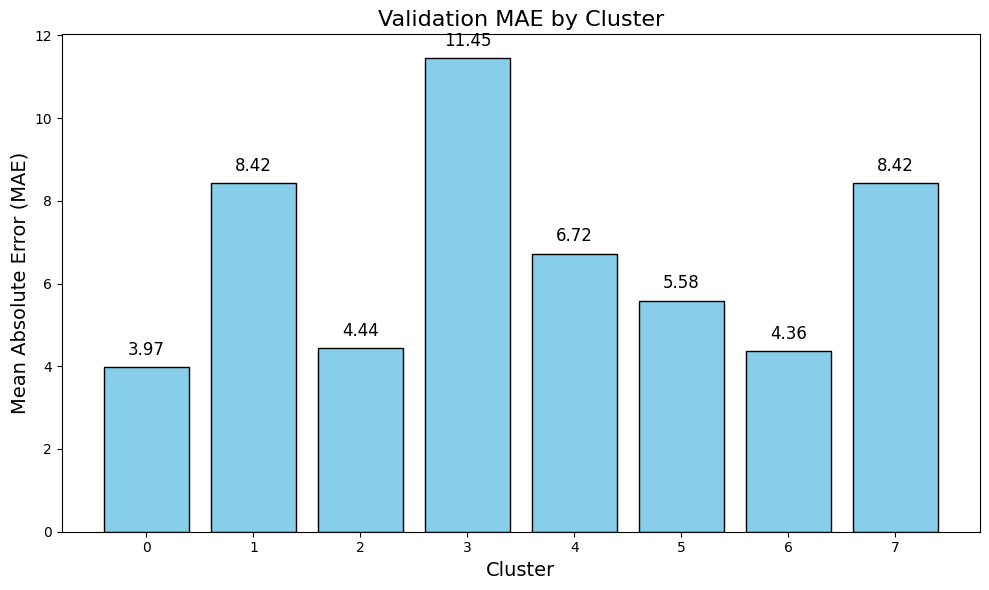

In [39]:
clusters = list(validation_scores_power.keys())
mae_values = list(validation_scores_power.values())

plt.figure(figsize=(10, 6))
plt.bar(clusters, mae_values, color='skyblue', edgecolor='black')
plt.xlabel("Cluster", fontsize=14)
plt.ylabel("Mean Absolute Error (MAE)", fontsize=14)
plt.title("Validation MAE by Cluster", fontsize=16)
plt.xticks(clusters)

for idx, mae in zip(clusters, mae_values):
    plt.text(idx, mae + 0.2, f"{mae:.2f}", ha="center", va="bottom", fontsize=12)
plt.tight_layout()
plt.show()


In [40]:
total_instances = len(validation_data)
weighted_sum = 0

for cluster, mae in validation_scores_power.items():
    one_hot_column_name = f'cluster_{cluster}'
    count = len(validation_data[validation_data[one_hot_column_name] == 1])
    weighted_sum += mae * count
    print(f"Cluster {cluster}: instances = {count}, MAE = {mae:.3f}")

weighted_avg_mae = weighted_sum / total_instances
print(f"\nTotal instances in validation data: {total_instances}")
print(f"Weighted Average MAE POWER: {weighted_avg_mae:.3f}")

Cluster 0: instances = 984, MAE = 3.974
Cluster 1: instances = 1224, MAE = 8.420
Cluster 2: instances = 2145, MAE = 4.444
Cluster 3: instances = 191, MAE = 11.451
Cluster 4: instances = 1167, MAE = 6.720
Cluster 5: instances = 1706, MAE = 5.583
Cluster 6: instances = 1592, MAE = 4.361
Cluster 7: instances = 764, MAE = 8.420

Total instances in validation data: 9773
Weighted Average MAE POWER: 5.799


In [ ]:
X_train = train_data[INPUT_FEATURES_MODEL]
y_train = train_data[TARGET_POWER]

dummy = DummyRegressor()
dummy.fit(X_train, y_train)

X_val = validation_data[INPUT_FEATURES_MODEL]
y_val = validation_data[TARGET_POWER]
y_pred = model.predict(X_val)

mae_dummy = mean_absolute_error(y_val, y_pred)
print(f"{mae_dummy=}")

In [49]:
if not POWER_MODEL_TRAINED:
    save_dir_power = Path("/home/henrik/projects/cedas2025/src/henrik/models2/power/")

    for cluster, model in models_power.items():
        model_name = f"power_{cluster}.pkl"
        pth = save_dir_power / model_name
        with open(pth, 'wb') as file:
            pickle.dump(model, file)


In [51]:
# put ID back
id_series = train_data["id"]
train_data_first_ten.insert(loc=0, column="id", value=id_series)

id_series = validation_data["id"]
validation_data_first_ten.insert(loc=0, column="id", value=id_series)

id_series = test_data["id"]
test_data_first_ten.insert(loc=0, column="id", value=id_series)


In [52]:
train_data_first_ten.head()

,id,nominal_power,location_id,soc_0,soc_1,soc_2,soc_3,soc_4,soc_5,soc_6,soc_7,soc_8,soc_9,power_0,power_1,power_2,power_3,power_4,power_5,power_6,power_7,power_8,power_9,cluster,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,temperatur
0,64754,100.0,150,53.0,54.0,54.0,55.0,56.0,56.0,58.0,59.0,59.0,60.0,15.04,14.76,15.01,15.06,15.03,15.04,15.42,15.33,15.40,15.33,6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-4
1,37916,150.0,101,10.0,13.0,15.0,18.0,20.0,23.0,25.0,28.0,30.0,33.0,66.27,60.10,64.59,64.91,68.69,60.86,62.18,62.24,66.42,66.54,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,123346,150.0,16,25.0,26.0,28.0,29.0,31.0,33.0,34.0,35.0,37.0,39.0,75.55,82.85,86.96,90.10,89.40,82.22,79.15,73.46,84.85,95.53,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-4
3,121473,180.0,45,35.0,36.0,37.0,38.0,39.0,40.0,41.0,42.0,43.0,44.0,0.00,41.06,42.00,42.48,42.60,42.96,42.96,43.44,44.16,44.29,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
4,41368,62.5,64,38.0,40.0,42.0,45.0,47.0,49.0,51.0,53.0,55.0,57.0,45.34,45.92,46.16,46.53,46.89,45.95,41.79,39.13,36.51,35.02,6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11


In [53]:
def predict_missing(df):
    predicted_power_cols = [f"power_{i}" for i in range(10, 40)]
    predicted_soc_cols   = [f"soc_{i}"   for i in range(10, 40)]

    # set to nan
    for col in predicted_power_cols + predicted_soc_cols:
        df[col] = float('nan')

    # predict power
    for cluster, model in models_power.items():

        one_hot_column_name = f"cluster_{cluster}"
        subset_mask = (df[one_hot_column_name] == 1)


        X_val = df.loc[subset_mask, INPUT_FEATURES_MODEL]
        y_pred = model.predict(X_val)
        df.loc[subset_mask, predicted_power_cols] = y_pred

    return df

In [54]:
# predicted_train = predict_missing(train_data_first_ten)

In [137]:
predicted_validation = predict_missing(validation_data_first_ten)

In [138]:
predicted_test = predict_missing(test_data_first_ten)

In [139]:
def wide_to_long(df):

    id_vars = [
        c for c in df.columns
        if not (c.startswith("soc_") or c.startswith("power_"))
    ]

    # soc and power cols
    soc_cols = [c for c in df.columns if c.startswith("soc_")]
    power_cols = [c for c in df.columns if c.startswith("power_")]

    # melt soc
    df_long_soc = df.melt(
        id_vars=id_vars,
        value_vars=soc_cols,
        var_name="soc_col",
        value_name="soc"
    )
    # grab subid
    df_long_soc["sub_id"] = df_long_soc["soc_col"].str.split("_").str[1].astype(int)
    df_long_soc.drop("soc_col", axis=1, inplace=True)

    # melt power
    df_long_power = df.melt(
        id_vars=id_vars,
        value_vars=power_cols,
        var_name="power_col",
        value_name="power"
    )
    # grab subid from power
    df_long_power["sub_id"] = df_long_power["power_col"].str.split("_").str[1].astype(int)
    df_long_power.drop("power_col", axis=1, inplace=True)
    
    # ge on id and subid
    df_merged = pd.merge(
        df_long_soc, df_long_power,
        on=id_vars + ["sub_id"], 
        how="inner"
    )

    final_cols = id_vars + ["sub_id", "soc", "power"]
    df_merged = df_merged[final_cols]
    return df_merged

In [140]:
pivoted_validation = wide_to_long(predicted_validation)
pivoted_validation.head()

,id,nominal_power,location_id,cluster,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,temperatur,sub_id,soc,power
0,26208,150.0,182,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-4,0,38.0,24.30
1,130625,180.0,44,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5,0,24.0,0.00
2,30165,350.0,6,5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,9.0,48.38
3,65622,62.5,31,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5,0,18.0,44.15
4,88233,150.0,23,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3,0,58.0,45.05


In [141]:
pivoted_validation.loc[pivoted_validation['id'] == 26208].head()

,id,nominal_power,location_id,cluster,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,temperatur,sub_id,soc,power
0,26208,150.0,182,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-4,0,38.0,24.30
9773,26208,150.0,182,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-4,1,38.0,24.11
19546,26208,150.0,182,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-4,2,39.0,24.02
29319,26208,150.0,182,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-4,3,39.0,25.09
39092,26208,150.0,182,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-4,4,40.0,26.00


In [142]:
pivoted_validation.to_parquet("/home/henrik/projects/cedas2025/src/henrik/saved_data2/wip_val.parquet")

In [156]:
# ----- OK NOW LETS LOAD ACTUAL VALIDATION DATA AND DO PREDICTIONS:
val_actual = pd.read_parquet("/home/henrik/projects/cedas2025/src/data/cedas2025_material/data/chargecurves_validation_holdback.parquet")

In [ ]:
def load_parse_predict(df):
    df = reshape_dataframe(df)

    # keep id's
    df_ids = df["id"]

    # remove power over 10 and soc over 10
    TARGET_POWER = [f'power_{i}' for i in range(10, 40)]
    TARGET_SOC = [f'soc_{i}' for i in range(10, 40)]

    # some data points include more than power_9 and soc_9
    df = df.drop(TARGET_POWER,axis=1)
    df = df.drop(TARGET_SOC,axis=1)
    df = df.drop(REMOVE,axis=1)
    df.head()

    # predict and add cluster label
    df_predict_labels = df[INPUT_FEATURES_CLUSTERING]
    print("df_predict_labels pre clustering")
    print(df_predict_labels.head())

    labels_df = clustering_pipeline.predict(df_predict_labels)
    df['cluster'] = labels_df

    # one hot encode cluster
    df = one_hot_encode_and_concat(df, encoder)

    print("df pre prediction")
    print(df_predict_labels.head())

    df_predicted = predict_missing(df)

    # add back id's
    df["id"] = df_ids
    df_pivoted = wide_to_long(df_predicted)

    # sort by subid
    df_pivoted.sort_values(['id', 'sub_id'], ascending=True).reset_index(drop=True)
    return df_pivoted

In [157]:
val_actual_predicted = load_parse_predict(val_actual)

In [164]:
val_actual_predicted.to_parquet("/home/henrik/projects/cedas2025/src/henrik/saved_data/validation_holdback_predictions.parquet")

In [165]:
val_predicted_fasit = pd.read_parquet("/home/henrik/projects/cedas2025/src/data/cedas2025_material/data/chargecurves_validation_holdback.parquet")

In [166]:
def check_id_subid_discrepancies(df1, df2): # made by chatgpt
    """
    Checks two dataframes for:
      - IDs that appear in one dataframe but not the other.
      - For each ID, whether the set of sub_ids differs between df1 and df2.
    Prints any discrepancies found.
    """
    set_df1_ids = set(df1['id'])
    set_df2_ids = set(df2['id'])

    ids_only_in_df1 = set_df1_ids - set_df2_ids
    ids_only_in_df2 = set_df2_ids - set_df1_ids

    if ids_only_in_df1:
        print(f"IDs only in df1: {ids_only_in_df1}")
    else:
        print("No IDs exclusively in df1.")

    if ids_only_in_df2:
        print(f"IDs only in df2: {ids_only_in_df2}")
    else:
        print("No IDs exclusively in df2.")

    all_ids = set_df1_ids.union(set_df2_ids)

    for i in sorted(all_ids):
        subids_in_df1 = set(df1.loc[df1['id'] == i, 'sub_id']) if i in set_df1_ids else set()
        subids_in_df2 = set(df2.loc[df2['id'] == i, 'sub_id']) if i in set_df2_ids else set()

        missing_in_df2 = subids_in_df1 - subids_in_df2
        missing_in_df1 = subids_in_df2 - subids_in_df1

        if missing_in_df2 or missing_in_df1:
            print(f"For ID {i}, sub_id mismatch found:")
            if missing_in_df2:
                print(f"  sub_ids in df1 not in df2: {missing_in_df2}")
            if missing_in_df1:
                print(f"  sub_ids in df2 not in df1: {missing_in_df1}")

check_id_subid_discrepancies(val_actual_predicted, val_predicted_fasit)

No IDs exclusively in df1.
No IDs exclusively in df2.
-----
